# Yolov EDA
1. **0단계 : 환경설정**<br>

2. **1단계 : 원본 데이터 탐색**<br>
JSON 원본 데이터를 분석하여 클래스 분포, Bbox 크기 등 데이터의 특징을 파악

3. **2단계 : 데이터 형식 변환**<br>
원본 COCO JSON 데이터를 YOLO가 학습할 수 있는 전용 .txt 라벨 형식으로 변환하고 폴더 구조 생성

4. **3단계 : 변환된 데이터 검증 (번역본 검수)**<br>
새로 생성된 .txt 라벨이 정확한지 확인하기 위해, 이미지 위에 Bbox를 직접 그려보며 시각적으로 검증

5. **4단계 : 최종 서류 정리 (data.yaml 생성)**<br>
데이터셋의 전체 정보(경로, 클래스 수, 클래스 이름)를 담은 최종 설정 파일인 data.yaml 생성

---
### 0단계 : 환경 설정
matplotlib, pandas 등 분석에 필요한 라이브러리를 불러오고, 데이터 폴더 경로를 변수로 지정합니다.

In [2]:
# ================================================================
# [0] 환경 설정 및 라이브러리 임포트
# ================================================================
"""
- 라이브러리 임포트 : os, json, Path, defaultdict/Counter, platform, numpy, pandas, GroupShuffleSplit, matplotlib.pyplot
- 한글 폰트 설정: Windows에서 Malgun Gothic 적용, 마이너스 기호 깨짐 방지
- 데이터 경로 설정 : PROJECT_ROOT=D:/datasets, IMG_DIR/ANN_DIR 하위 경로 생성
- 경로 검증 : assert로 IMG_DIR, ANN_DIR 존재 확인
- 확인 출력 : 이미지/어노테이션 폴더 경로 콘솔 표시
"""

# 표준 라이브러리
import os  # 파일/폴더 경로, 목록, 환경변수 등
import json  # JSON 직렬화/역직렬화
import random
from pathlib import Path  # 경로 처리(결합, 탐색, I/O)
from collections import defaultdict, Counter  # 기본값 dict, 빈도수 집계

import platform  # OS 판별(Windows/macOS/Linux)

# 서드파티 라이브러리
import numpy as np  # 수치 계산과 배열 연산
import pandas as pd  # 표 형식 데이터 처리/분석
from sklearn.model_selection import GroupShuffleSplit  # 그룹 단위 데이터 분할
import matplotlib.pyplot as plt  # 시각화
from PIL import Image, ImageDraw, ImageFont

# --- 한글 폰트 설정 (그래프 깨짐 방지) ---
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# --- 데이터 경로 ---
# 1. 이 프로젝트의 최상위 폴더 경로 하나만 설정
PROJECT_ROOT = Path("D:/datasets")  # <- 각자 실제 위치에 맞게 수정

# 2. 하위 경로는 자동 생성
IMG_DIR = PROJECT_ROOT / "train_images"
ANN_DIR = PROJECT_ROOT / "train_annotations"

# 존재 확인
assert IMG_DIR.exists(), f"이미지 폴더를 찾을 수 없습니다: {IMG_DIR}"
assert ANN_DIR.exists(), f"어노테이션 폴더를 찾을 수 없습니다: {ANN_DIR}"

print("데이터 경로 설정 완료!")
print(f"이미지 폴더: {IMG_DIR}")
print(f"어노테이션 폴더: {ANN_DIR}")

데이터 경로 설정 완료!
이미지 폴더: D:\datasets\train_images
어노테이션 폴더: D:\datasets\train_annotations


---
### 1단계 : 원본 데이터 탐색

- **목표**<br>
: 변환 작업을 시작하기 전에 원본 데이터의 상태를 완벽히 파악한다.

- **1-1. 모든 Annotation 정보 통합 로드**<br>
흩어져 있는 모든 JSON 파일을 단 한 번만 순회하여, 이미지, 어노테이션, 카테고리, 그룹핑 정보를<br> 각각의 변수에 체계적으로 저장합니다.

- **1-2. 통계적 데이터 분석**<br>
수집된 정보를 바탕으로 클래스 분포를 분석하여 데이터 불균형을 확인하고, <br>
Bbox의 너비/높이/비율을 분석하여 데이터에 포함된 객체들의 크기 특성을 파악합니다.

- **1.3. 시각적 데이터 검증**<br>
원본 이미지 몇 개를 무작위로 뽑아, 그 위에 원본 JSON의 Bbox 정보를 직접 그려봅니다.<br> 
이를 통해 라벨링이 잘못되지는 않았는지 눈으로 확인합니다.

In [ ]:
# ================================================================
# --- 1.1 : 단 한 번의 순회로 모든 정보 수집 ---
# ================================================================
"""
총 4,526개의 원본 JSON 파일을 성공적으로 읽어들여, 
데이터셋 전체에 대한 핵심 정보를 성공적으로 수집했습니다.

결과 항목별 상세 설명 :
- 총 4526개의 JSON 파일
- 총 4526개의 어노테이션과 73개의 클래스
: 모든 JSON 파일을 통틀어, 총 4,526개의 바운딩 박스(알약 객체) 정보가 있으며,
그 알약들의 종류는 중복을 제외하고 총 73가지임을 의미합니다.

- 정보를 수집한 총 이미지 개수: 1489
: 어노테이션들이 참조하고 있는 고유한 이미지 파일의 총 개수입니다.

가장 중요한 점은 JSON 파일 수(4526)와 어노테이션 수(4526)는 같지만, 
이미지 수(1489)는 훨씬 적다는 것입니다. 
    
이는 이 데이터셋이 '이미지 하나당 JSON 파일 하나'가 아니라, 
'알약(어노테이션) 하나당 JSON 파일 하나'인 독특한 구조임을 의미합니다.
    
따라서 평균적으로 이미지 한 장당 약 3개(4526 / 1489 ≈ 3)의 
JSON 파일이 할당되어 있는 셈이며, 우리가 작성한 코드는 
이렇게 흩어진 정보들을 성공적으로 하나로 모은 것입니다.
"""

all_annotations = []            # 모든 어노테이션 객체
img_to_anns = defaultdict(list) # 이미지 ID별 어노테이션
all_categories = {}             # {ID: 이름} 카테고리 정보
img_info_dict = {}              # {ID: info} 이미지 정보 (w,h,파일명 등)
group_keys = {}                 # 데이터 누수 방지를 위한 그룹 키

json_files = list(ANN_DIR.rglob("*.json"))
print(f"총 {len(json_files)}개의 JSON 파일을 분석합니다.")

for jf in json_files:
    with open(jf, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 이미지 정보 수집
    for img in data.get('images', []):
        img_id = img['id']
        img_info_dict[img_id] = img
        
        stem = Path(img['file_name']).stem
        key = stem
        for suf in ("_70", "_75", "_90"):
            if stem.endswith(suf):
                key = stem[:-len(suf)]
        group_keys[img_id] = key

    # 카테고리(클래스, 알약종류) 정보 수집
    for cat in data.get('categories', []):
        all_categories[cat['id']] = cat['name']

    # 어노테이션 정보 수집
    for ann in data.get('annotations', []):
        img_to_anns[ann['image_id']].append(ann)
        all_annotations.append(ann)

print(f"총 {len(all_annotations)}개의 어노테이션과 {len(all_categories)}개의 클래스를 찾았습니다.")
print(f"정보를 수집한 총 이미지 개수: {len(img_info_dict)}")

총 4526개의 JSON 파일을 분석합니다.
총 4526개의 어노테이션과 73개의 클래스를 찾았습니다.
정보를 수집한 총 이미지 개수: 1489


--- 클래스 분포 (상위 10개) ---
                 name  count
0  기넥신에프정(은행엽엑스)(수출용)    514
1         일양하이트린정 2mg    240
2          보령부스파정 5mg    180
3         뮤테란캡슐 100mg    172
4         가바토파정 100mg    143
5       동아가바펜틴정 800mg    139
6        아토젯정 10/40mg    113
7            리바로정 4mg    111
8           리피토정 20mg    109
9        로수젯정10/5밀리그램    108

--- 클래스 분포 (하위 5개) ---
            name  count
68   졸로푸트정 100mg     11
69    쿠에타핀정 25mg     10
70  자이프렉사정 2.5mg      9
71    렉사프로정 15mg      9
72   브린텔릭스정 20mg      7


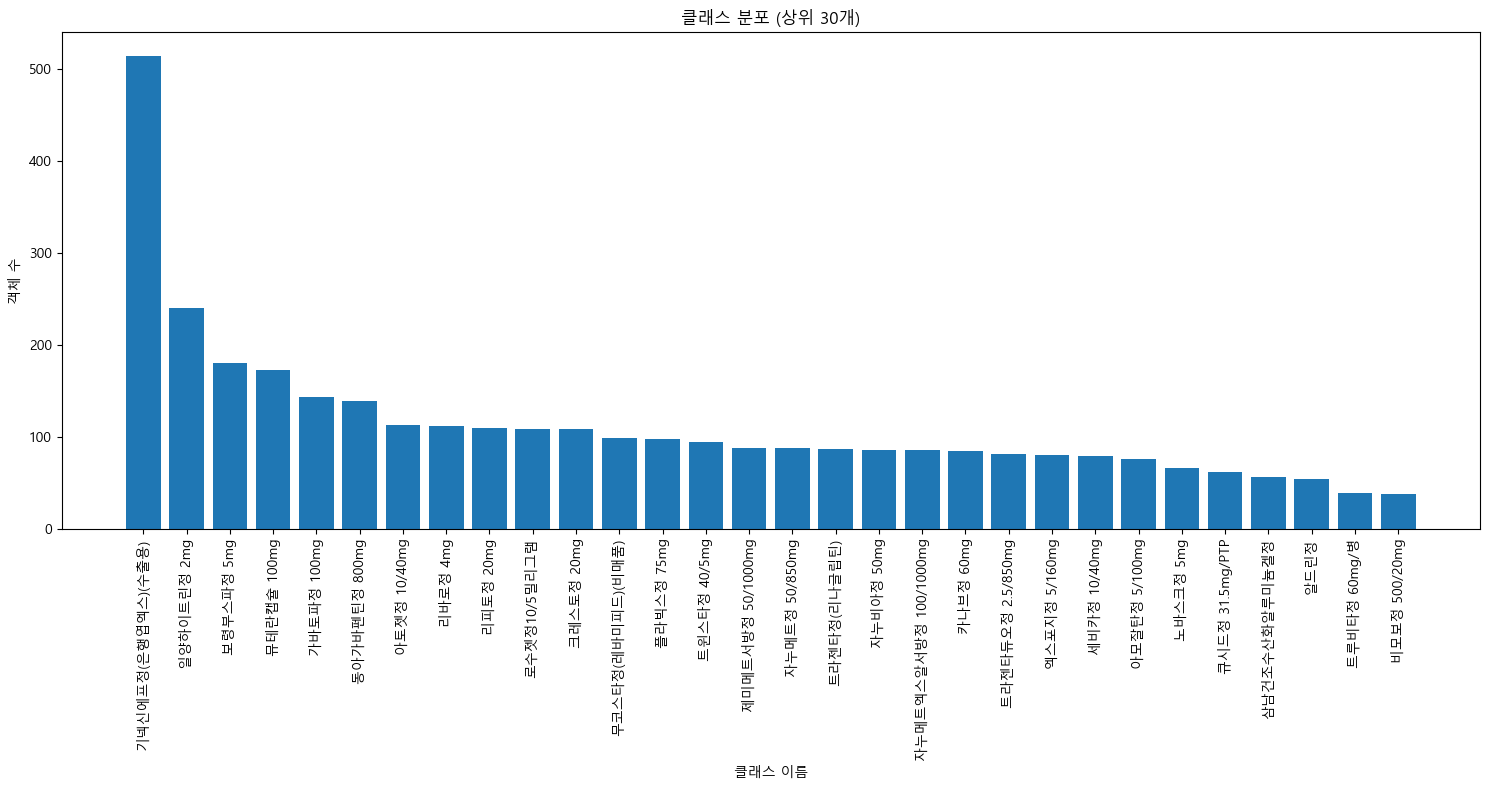

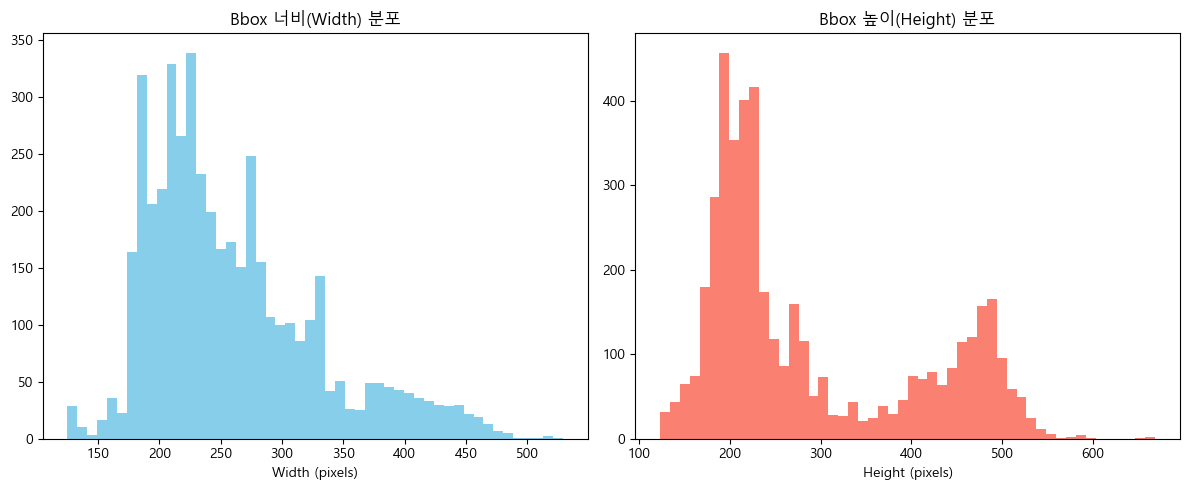

In [ ]:
# ================================================================
# --- 1.2 : 통계적 데이터 분석 ---
# ================================================================
"""
1.1 단계에서 메모리로 불러온 전체 데이터에 대한 통계적 분석을 수행

[Process]
1. 클래스 분포 분석 (Class Distribution Analysis) :
- 모든 어노테이션을 바탕으로 각 클래스(알약 종류)가 몇 개씩 있는지 집계
- Pandas DataFrame으로 변환하여 가장 개수가 많은 10개 클래스와
  가장 적은 5개 클래스를 텍스트로 출력합니다.
- 상위 30개 클래스에 대한 막대그래프를 그려, 
클래스 간의 데이터 불균형을 시각적으로 확인

2. Bbox 특징 분석 (Bbox Characteristic Analysis) :
- 모든 바운딩 박스의 너비(width)와 높이(height) 정보를 추출합니다.
- 너비와 높이 각각에 대한 히스토그램을 그려, 데이터셋에 포함된 알약들의
  전반적인 크기 분포와 경향을 파악합니다.

이 코드를 통해 데이터의 가장 큰 특징이자 해결 과제인 '클래스 불균형' 문제를
정량적으로 파악하고, 객체들의 '물리적인 크기 경향'을 이해하여
향후 모델링 전략을 세우는 데 핵심적인 정보를 얻습니다.
"""
# 1. 클래스 분포 분석
# Counter를 사용해 각 클래스 ID가 몇 번 등장했는지 집계합니다.
class_counts = Counter(ann['category_id'] for ann in all_annotations)

# 분석하기 편하도록 Pandas DataFrame으로 변환합니다.
df_classes = pd.DataFrame({
    'name': [all_categories.get(cid, 'N/A') for cid in class_counts.keys()],
    'count': list(class_counts.values())
}).sort_values('count', ascending=False).reset_index(drop=True)

# 가장 많은 상위 10개 클래스와 가장 적은 하위 5개 클래스를 출력합니다.
print("--- 클래스 분포 (상위 10개) ---")
print(df_classes.head(10))
print("\n--- 클래스 분포 (하위 5개) ---")
print(df_classes.tail(5))

# 분포를 한눈에 보기 위해 상위 30개 클래스를 막대그래프로 시각화합니다.
plt.figure(figsize=(15, 8))
plt.bar(df_classes['name'][:30], df_classes['count'][:30])
plt.xlabel('클래스 이름')
plt.ylabel('객체 수')
plt.title('클래스 분포 (상위 30개)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 2. Bbox 특징 분석
# 모든 어노테이션에서 너비(width)와 높이(height) 정보만 추출합니다.
widths = [ann['bbox'][2] for ann in all_annotations]
heights = [ann['bbox'][3] for ann in all_annotations]

# 너비와 높이의 분포를 히스토그램으로 시각화하여 데이터의 경향을 파악합니다.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=50, color='skyblue')
plt.title('Bbox 너비(Width) 분포')
plt.xlabel('Width (pixels)')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=50, color='salmon')
plt.title('Bbox 높이(Height) 분포')
plt.xlabel('Height (pixels)')

plt.tight_layout()
plt.show()

### 1.2 결론
**1. 극심한 클래스 불균형**
- 가장 많은 '기넥신에프정'(514개)은 가장 적은 '브린텔릭스정'(7개)보다 약 73배 많습니다.<br>
상위 몇 개 클래스가 데이터의 대부분을 차지하고, 나머지 클래스들은 매우 적은 수의 샘플만 가지고 있습니다.

- 의미 :<br> 
모델 학습에 가장 큰 어려움이 될 '클래스 불균형' 문제입니다.<br> 
모델은 데이터가 많은 클래스는 쉽게 학습하지만,<br> 
학습할 기회가 거의 없는 소수 클래스는 '찍기'에 가까운 예측을 할 가능성이 높습니다.<br> 
**이는 전체 mAP 점수를 낮추는 가장 큰 원인이 될 것입니다.**

**2. 주요 특징 : 명확히 나뉘는 두 종류의 알약 형태**
- Bbox 히스토그램, 특히 'Bbox 높이(Height) 분포' 그래프를 보면 매우 명확한 특징이 나타납니다.<br>
200px 근처에 높은 봉우리가 하나 있고, 500px 근처에 또 다른 큰 봉우리가 있습니다.<br> 
너비(Width) 분포는 상대적으로 완만하지만, 높이 분포는 두 그룹으로 명확하게 나뉩니다.

- 이는 우리 데이터셋에 원형에 가까운 '짧은 알약' 그룹과<br> 
캡슐처럼 생긴 '길쭉한 알약' 그룹이 섞여 있다는 강력한 증거입니다.<br> 
모델은 이 두 가지 다른 형태의 객체를 모두 잘 감지할 수 있어야 합니다.

**향후 모델링 전략**
1. **클래스 불균형 해결에 집중 :**<br> 
학습 시 **데이터 증강(Augmentation)** 을 적용할 때,<br> 
모든 클래스에 동일하게 적용하기보다 데이터가 적은 하위 클래스에 대해<br> 
더 강하고 다양한 증강 기법을 적용하는 '타겟 증강' 전략이 필수적입니다.

2. **형태 다양성 인지 :**<br>
YOLO 모델은 다양한 형태의 객체를 잘 감지하지만,<br> 
만약 학습 후 특정 형태(e.g., 길쭉한 캡슐)의 알약을 자주 놓친다면,<br> 
이 분석 결과를 바탕으로 원인을 파악하고 데이터 증강 방식을 조절하는 등의 조치를 취할 수 있습니다.

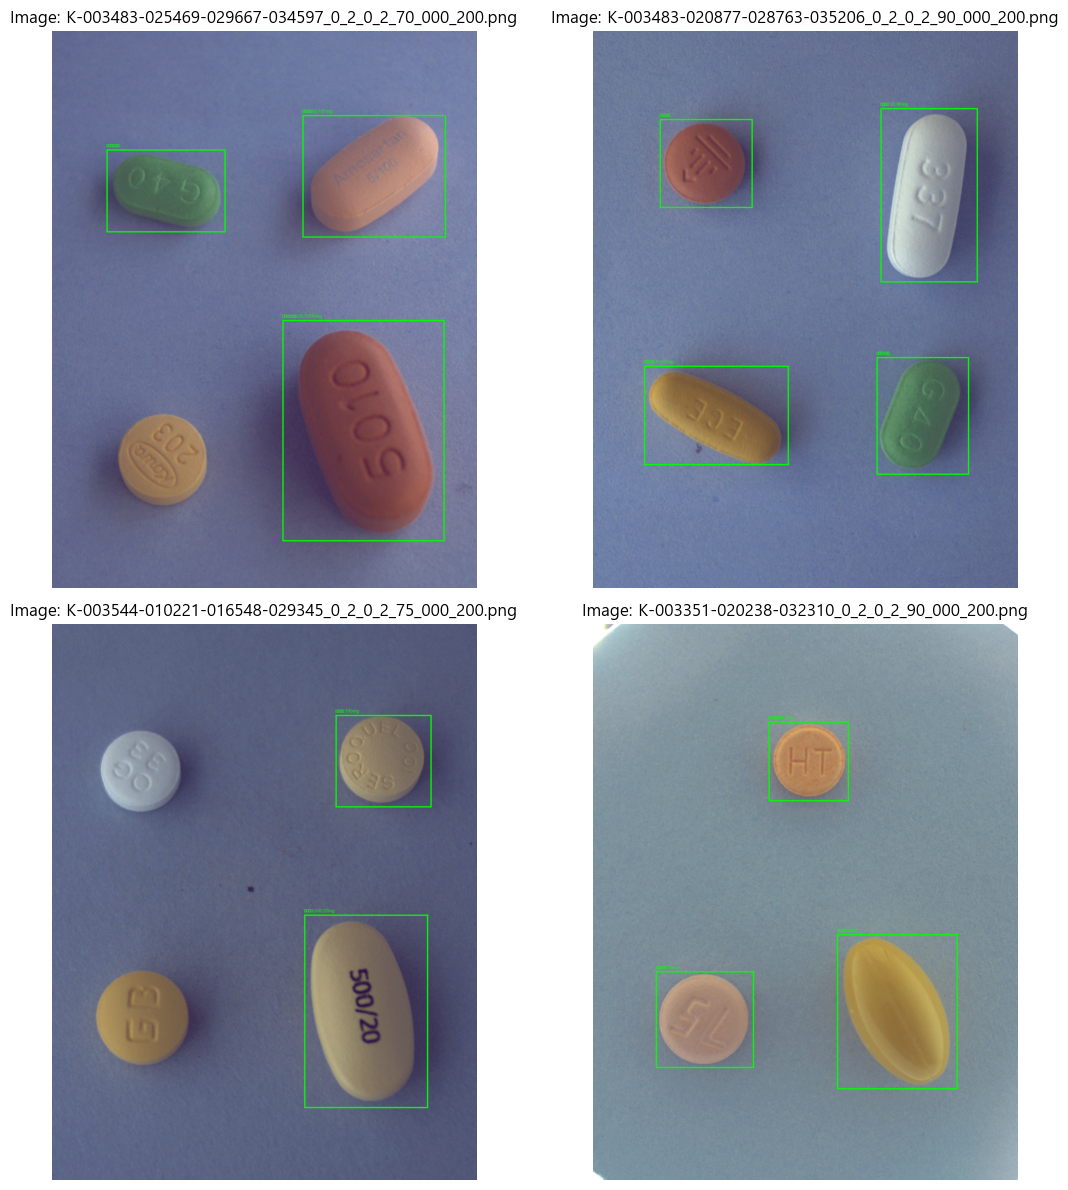

--- 이미지당 알약 개수 통계 ---
평균: 3.04 개
최소: 1 개
최대: 4 개

--- 개수별 이미지 분포 ---
알약 1개: 64 장
알약 2개: 302 장
알약 3개: 634 장
알약 4개: 489 장


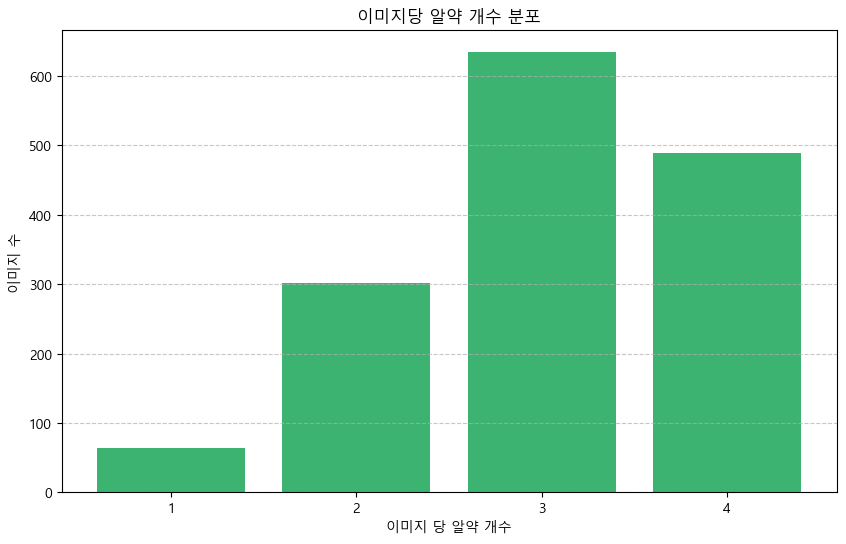

In [ ]:
# ================================================================
# 섹션 1: 이미지 위에 BBox를 그려 눈으로 라벨 상태 확인
# ================================================================

# 1) 무작위로 몇 장 선택 (최대 4장)
sample_ids = random.sample(list(img_to_anns.keys()), k=min(4, len(img_to_anns)))

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, img_id in enumerate(sample_ids):
    img_info = img_info_dict.get(img_id)
    if not img_info:
        continue

    # 2) 이미지 파일 경로 확인 후 열기
    img_path = IMG_DIR / img_info['file_name']
    if not img_path.exists():
        print(f"경고: 이미지 파일을 찾을 수 없습니다 - {img_path}")
        continue
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    # 3) 해당 이미지의 모든 BBox와 클래스 이름 표시
    for ann in img_to_anns[img_id]:
        x, y, w, h = ann['bbox']
        cat_name = all_categories.get(ann['category_id'], 'Unknown')
        draw.rectangle([x, y, x + w, y + h], outline="lime", width=3)  # 박스
        draw.text((x, max(0, y - 15)), cat_name.split('(')[0].strip(), fill="lime")  # 라벨

    # 4) 화면에 표시
    axes[i].imshow(img)
    axes[i].set_title(f"Image: {img_info['file_name']}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# ================================================================
# 섹션 2: 이미지당 객체(알약) 수 통계 및 시각화
# ================================================================

# 1) 이미지별 어노테이션 개수 리스트 생성 (어노테이션 0개 이미지도 포함)
bbox_counts_per_image = [len(img_to_anns[img_id]) for img_id in img_info_dict.keys()]

# 2) 동일 개수끼리 몇 장인지 집계
count_distribution = Counter(bbox_counts_per_image)

# 3) 요약 통계 출력
print("--- 이미지당 알약 개수 통계 ---")
print(f"평균: {np.mean(bbox_counts_per_image):.2f} 개")
print(f"최소: {np.min(bbox_counts_per_image)} 개")
print(f"최대: {np.max(bbox_counts_per_image)} 개")

print("\n--- 개수별 이미지 분포 ---")
for num_pills, num_images in sorted(count_distribution.items()):
    print(f"알약 {num_pills}개: {num_images} 장")

# 4) 막대그래프로 시각화
plt.figure(figsize=(10, 6))
plt.bar(count_distribution.keys(), count_distribution.values(), color='mediumseagreen')
plt.xlabel('이미지 당 알약 개수')
plt.ylabel('이미지 수')
plt.title('이미지당 알약 개수 분포')
plt.xticks(sorted(count_distribution.keys()))  # 정렬된 정수 눈금
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

---
### 2단계 : 데이터 형식 변환

**목표**<br>
: 원본 COCO JSON 데이터를 YOLO가 학습할 수 있는 전용 .txt 라벨과 폴더 구조로 변환

**2-1. 데이터 분할 (Train/Validation Split)**<br>
1단계에서 생성한 그룹 키를 사용하여, 데이터 누수를 방지하는 방식으로 전체 이미지 ID를 학습용과 검증용으로 분할

**2-2. YOLO 폴더 구조 생성**<br>
YOLO 학습에 필요한 공식 폴더 구조(images/train, labels/train 등)를 미리 생성하여 변환된 파일들을 담을 공간을 마련

**2-3. 이미지 복사 및 TXT 라벨 변환**<br>
분할된 목록에 따라 이미지를 해당 폴더로 복사하고, 각 이미지의 어노테이션을 YOLO 형식(.txt)으로 변환합니다. 이 과정에서 Bbox 좌표를 정규화하고 중심점 기준으로 변경하여 저장합니다.<br>

In [ ]:
# ================================================================
# --- 2.1: 데이터 분할 (GroupShuffleSplit 사용) ---
# ================================================================
from sklearn.model_selection import GroupShuffleSplit # 그룹 단위 데이터 분할

# 분할할 대상인 이미지 ID와 그룹 정보를 리스트로 변환
# 1단계에서 생성한 변수들을 사용합니다.
image_ids = np.array(list(img_info_dict.keys()))
groups = np.array([group_keys.get(i, 'default') for i in image_ids])

# 80%를 학습용, 20%를 검증용으로 분할하도록 설정
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, val_idx = next(gss.split(image_ids, groups=groups))

# 분할된 인덱스를 사용하여 실제 이미지 ID 리스트 생성
train_ids = image_ids[train_idx]
val_ids = image_ids[val_idx]

print(f"데이터 분할 완료:")
print(f" - 학습용 데이터 (Train) : {len(train_ids)}개 이미지")
print(f" - 검증용 데이터 (Validation) : {len(val_ids)}개 이미지")

데이터 분할 완료:
 - 학습용 데이터 (Train) : 1191개 이미지
 - 검증용 데이터 (Validation) : 298개 이미지


In [ ]:
# ================================================================
# --- 2.2: YOLO 폴더 구조 생성 및 데이터 변환/복사 ---
# ================================================================
import shutil # 파일 복사를 위한 라이브러리

"""
YOLO가 요구하는 공식적인 폴더 구조(images/train, labels/train 등)를 실제로 디스크에 생성합니다. 
번역된 서류들을 담을 빈 파일 캐비닛을 미리 준비하는 것과 같습니다.
"""
# --- 새 YOLO용 경로 설정 --- 
# 폴더가 없으면 새롭게 생성하는 로직이 아래에 있습니다.
YOLO_DATA_DIR = PROJECT_ROOT / 'data_yolo'
IMG_TRAIN_DIR = YOLO_DATA_DIR / 'images' / 'train'
IMG_VAL_DIR = YOLO_DATA_DIR / 'images' / 'val'
LBL_TRAIN_DIR = YOLO_DATA_DIR / 'labels' / 'train'
LBL_VAL_DIR = YOLO_DATA_DIR / 'labels' / 'val'

# 폴더가 없으면 새로 생성
for d in [IMG_TRAIN_DIR, IMG_VAL_DIR, LBL_TRAIN_DIR, LBL_VAL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

"""
데이터의 73개 알약 이름('기넥신에프정' 등)을 YOLO가 사용할 숫자 ID(0, 1, 2...)와 
짝을 맞춰주는 '번역용 단어장'(name_to_id)을 만듭니다. 
'기넥신에프정'은 0번, '뮤테란캡슐'은 1번... 이런 식입니다.
"""
# --- 전역 클래스 이름 -> ID(0-based) 맵 생성 ---
# 1단계에서 수집한 all_categories를 사용합니다.
class_names = sorted(list(set(all_categories.values())))
name_to_id = {name: i for i, name in enumerate(class_names)}

"""
convert_to_yolo_format 이라는 이름의 '자동 번역기'를 만드는 과정입니다. 
이 번역기는 이미지 목록을 받아서 다음의 일들을 순서대로 처리합니다.
    1. 이미지 복사 : 원본 이미지를 새로운 YOLO용 images 폴더로 복사합니다.
    
    2. 라벨 번역 및 계산 
    : 이미지에 속한 각 알약(어노테이션)에 대해, 
      COCO 형식의 Bbox 좌표(x, y, w, h)를 
      YOLO 형식(클래스ID, x_center, y_center, norm_w, norm_h)으로 
      변환하고, 모든 값을 0~1 사이로 정규화합니다.
      
    3. .txt 파일로 저장 
    : 번역된 라벨들을 한 줄씩 모아, 
    이미지 파일명과 동일한 이름의 .txt 파일로 labels 폴더에 저장합니다.
"""
# --- 변환을 수행하는 함수 정의 ---
def convert_to_yolo_format(image_ids, img_save_dir, lbl_save_dir):
    """주어진 이미지 ID들에 대해 이미지 복사 및 라벨 변환을 수행"""
    for img_id in image_ids:
        img_info = img_info_dict.get(img_id)
        if not img_info: continue
            
        img_name = img_info['file_name']
        img_w = img_info['width']
        img_h = img_info['height']
        
        # 1. 원본 이미지를 YOLO용 폴더로 복사
        source_img_path = IMG_DIR / img_name
        if source_img_path.exists():
            shutil.copy(source_img_path, img_save_dir / img_name)
        
        # 2. TXT 라벨 파일 생성
        yolo_lines = []
        for ann in img_to_anns[img_id]:
            cat_name = all_categories[ann['category_id']]
            cls_id = name_to_id[cat_name]
            
            x, y, w, h = ann['bbox']
            # 좌표 정규화 (0~1 사이 비율 값으로) 및 중심점 계산
            x_center = (x + w / 2) / img_w
            y_center = (y + h / 2) / img_h
            norm_w = w / img_w
            norm_h = h / img_h
            
            yolo_lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}")
            
        # .txt 파일로 저장
        label_path = lbl_save_dir / f"{Path(img_name).stem}.txt"
        with open(label_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(yolo_lines))

# --- 함수 실행 ---
print("Train 데이터셋 변환 시작!")
convert_to_yolo_format(train_ids, IMG_TRAIN_DIR, LBL_TRAIN_DIR)
print("Validation 데이터셋 변환 시작!")
convert_to_yolo_format(val_ids, IMG_VAL_DIR, LBL_VAL_DIR)

print("\nYOLO 데이터 변환 완료!")

Train 데이터셋 변환 시작...
Validation 데이터셋 변환 시작...

YOLO 데이터 변환 완료!


In [ ]:
# ================================================================
# --- 2.3: data.yaml 파일 생성 ---
# ================================================================
import yaml

# --- YAML 파일에 저장할 내용 정의 ---
# 경로는 프로젝트 최상위 폴더(PROJECT_ROOT)를 기준으로 한 상대 경로로 지정하는 것이 일반적입니다.
# str()로 변환하고, 윈도우의 역슬래시(\)를 슬래시(/)로 바꿔줍니다.
train_path = str(IMG_TRAIN_DIR.relative_to(PROJECT_ROOT)).replace('\\', '/')
val_path = str(IMG_VAL_DIR.relative_to(PROJECT_ROOT)).replace('\\', '/')

data_yaml = {
    'train': train_path,
    'val': val_path,
    'nc': len(class_names),
    'names': class_names
}

# --- YAML 파일 저장 ---
# configs 폴더가 없다면 새로 생성
CONFIG_DIR = PROJECT_ROOT / 'configs'
CONFIG_DIR.mkdir(exist_ok=True)
yaml_path = CONFIG_DIR / 'pills_data.yaml'

with open(yaml_path, 'w', encoding='utf-8') as f:
    # allow_unicode=True: 한글이 깨지지 않도록 저장
    # sort_keys=False: 딕셔너리 순서 그대로 저장
    yaml.dump(data_yaml, f, allow_unicode=True, sort_keys=False)

print(f"YOLO 데이터셋 설명 파일 생성 완료!")
print(f"  -> 저장 위치: {yaml_path}")
print("\n--- 파일 내용 미리보기 ---")
print(yaml.dump(data_yaml, allow_unicode=True, sort_keys=False))

YOLO 데이터셋 설명 파일 생성 완료!
  -> 저장 위치: D:\datasets\configs\pills_data.yaml

--- 파일 내용 미리보기 ---
train: data_yolo/images/train
val: data_yolo/images/val
nc: 73
names:
- 가바토파정 100mg
- 글리아타민연질캡슐
- 글리틴정(콜린알포세레이트)
- 기넥신에프정(은행엽엑스)(수출용)
- 낙소졸정 500/20mg
- 노바스크정 5mg
- 놀텍정 10mg
- 뉴로메드정(옥시라세탐)
- 다보타민큐정 10mg/병
- 동아가바펜틴정 800mg
- 라비에트정 20mg
- 란스톤엘에프디티정 30mg
- 레일라정
- 렉사프로정 15mg
- 로수바미브정 10/20mg
- 로수젯정10/5밀리그램
- 리렉스펜정 300mg/PTP
- 리리카캡슐 150mg
- 리바로정 4mg
- 리피로우정 20mg
- 리피토정 20mg
- 마도파정
- 맥시부펜이알정 300mg
- 메가파워정 90mg/병
- 무코스타정(레바미피드)(비매품)
- 뮤테란캡슐 100mg
- 보령부스파정 5mg
- 브린텔릭스정 20mg
- 비모보정 500/20mg
- 비타비백정 100mg/병
- 삐콤씨에프정 618.6mg/병
- 삼남건조수산화알루미늄겔정
- 세비카정 10/40mg
- 스토가정 10mg
- 신바로정
- 써스펜8시간이알서방정 650mg
- 쎄로켈정 100mg
- 아모잘탄정 5/100mg
- 아빌리파이정 10mg
- 아질렉트정(라사길린메실산염)
- 아토르바정 10mg
- 아토젯정 10/40mg
- 알드린정
- 에빅사정(메만틴염산염)(비매품)
- 에스원엠프정 20mg
- 에어탈정(아세클로페낙)
- 엑스포지정 5/160mg
- 오마코연질캡슐(오메가-3-산에틸에스테르90)
- 울트라셋이알서방정
- 일양하이트린정 2mg
- 자누메트엑스알서방정 100/1000mg
- 자누메트정 50/850mg
- 자누비아정 50mg
- 자이프렉사정 2.5mg
- 제미메트서방정 50/1000mg
- 조인스정 200mg
- 졸

---

### 3단계 : 변환된 데이터 검증